# QuadrupoleTrapAnalysis

This Notebook works with the `QuadrupoleTrapSimulation.xml` file located in `${KASPERSYS}/config/Kassiopeia/Examples`. The file contains a model of an quadrupole trap with three electrodes embedded in a magnetic coil.

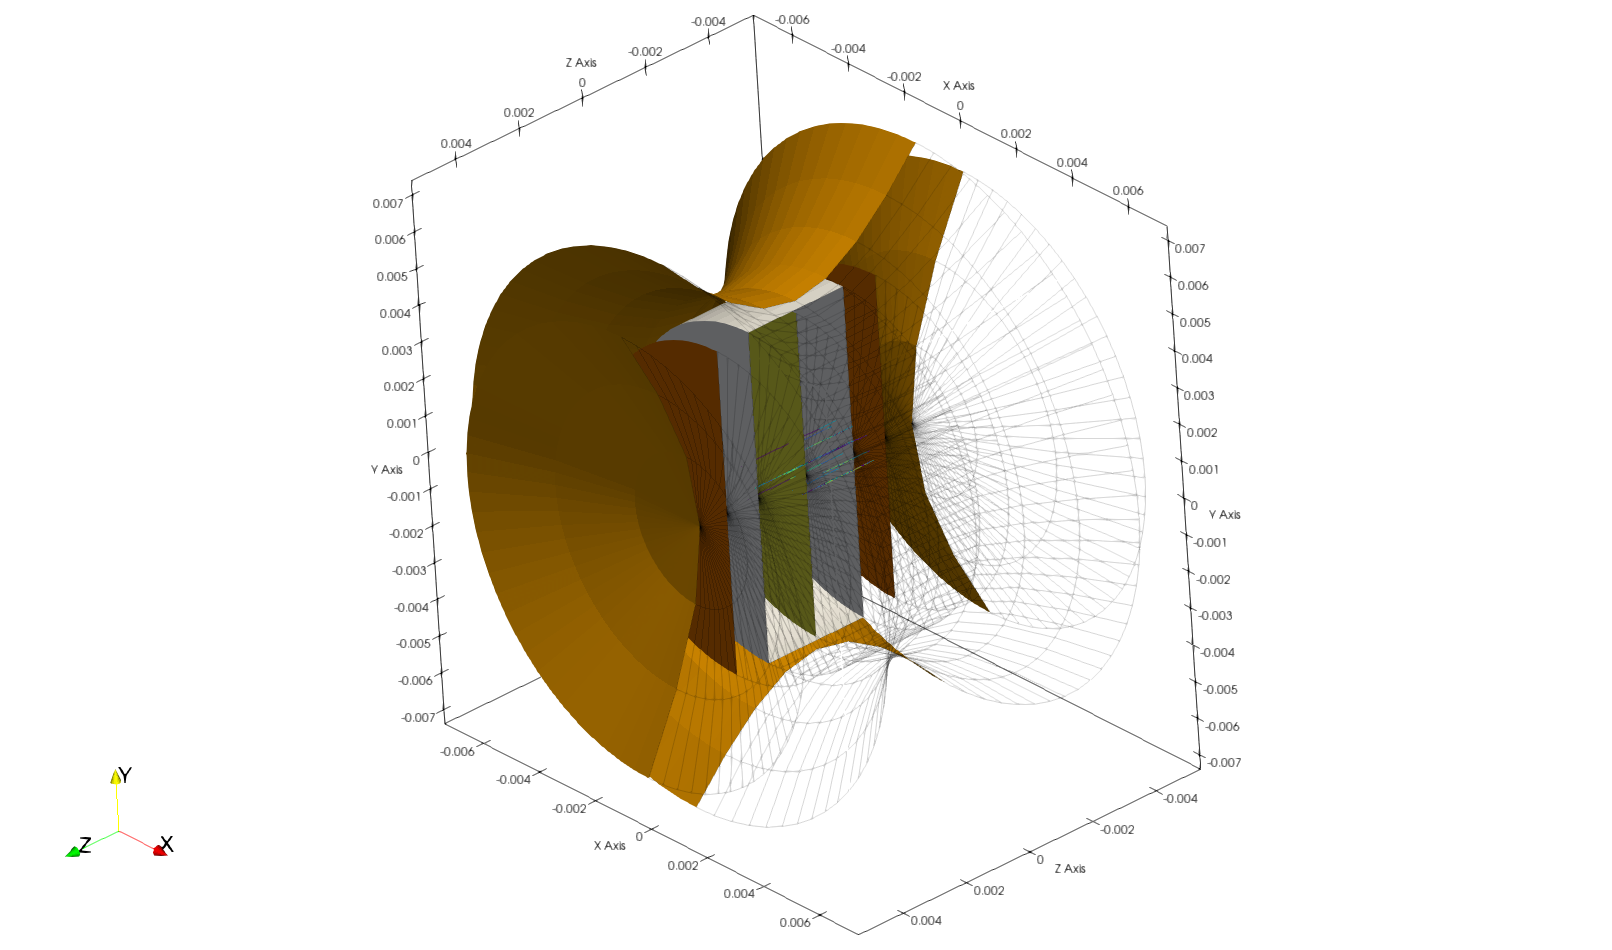


### Run this _Kassiopeia_ command to generate the output file:

```
Kassiopeia ${KASPERSYS}/config/Kassiopeia/Examples/QuadrupoleTrapSimulation.xml
```

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Setup modules

import os
import numpy as np
import pandas as pd
try:
    import uproot3 as uproot  # try this if newer uproot does not work
except ModuleNotFoundError:
    import uproot
import matplotlib.pyplot as plt

WORKDIR = os.path.expandvars('$HOME/kasper.git/install/output/Kassiopeia/')

if not os.path.exists(WORKDIR):
    raise RuntimeError(f"Workspace directory does not exist: {WORKDIR}")

In [3]:
# Open output file

file_name = WORKDIR + 'QuadrupoleTrapSimulation.root'
if not os.path.exists(file_name):
    raise RuntimeError(f"Output file '{file_name}' does not exist. Please run the simulation first.")

data = uproot.open(file_name)

## Method 1

This method uses dataframes to iterate over each output track and process step data in the `component_step_cell` group. The steps that correspond to each track are selected by a boolean mask.

In [4]:
# Read data structures
df0 = data['TRACK_DATA'].pandas.df()
df1 = data['component_step_cell_DATA'].pandas.df()
df1p = data['component_step_cell_PRESENCE'].pandas.df()

# Iterate over tracks and assign to step data
for track_id, first_step_index, last_step_index in zip(df0['TRACK_INDEX'], df0['FIRST_STEP_INDEX'], df0['LAST_STEP_INDEX']):

    step_mask = np.full(df1.shape[0], False)
    
    start_index = 0
    for first_valid, valid_length in zip(df1p['INDEX'], df1p['LENGTH']):
        last_valid = first_valid + valid_length - 1

        if first_valid >= first_step_index and last_valid <= last_step_index:
            step_mask[start_index:start_index+valid_length] = True

        if start_index > last_step_index:
            break

        start_index += valid_length
        
    # Select data of current track
    steps_moment = df1['orbital_magnetic_moment'][step_mask]
    max_moment = np.max(steps_moment)
    min_moment = np.min(steps_moment)
    
    # Compute result
    deviation = 2.0 * (max_moment - min_moment) / (max_moment + min_moment)
    print("extrema for track #{:d} <{:g}>".format(track_id, deviation))


extrema for track #0 <nan>
extrema for track #1 <0.000155068>
extrema for track #2 <0.000187115>
extrema for track #3 <0.237179>
extrema for track #4 <0.000142933>
extrema for track #5 <0.00011403>
extrema for track #6 <0.000433223>
extrema for track #7 <nan>


## Method 2

This method uses dataframes to iterate over each output track and process step data in the `component_step_cell` group. The steps that correspond to each track are selected by the dataframe's `track_id` column. This method allows more complex data selections through the `df.query()` method.

In [5]:
# Read data structures
df0 = data['TRACK_DATA'].pandas.df()
df1 = data['component_step_cell_DATA'].pandas.df()
df1p = data['component_step_cell_PRESENCE'].pandas.df()

# Extend step data for merging
df1 = df1.assign(track_id=np.nan)

# Iterate over tracks and assign to step data
for track_id, first_step_index, last_step_index in zip(df0['TRACK_INDEX'], df0['FIRST_STEP_INDEX'], df0['LAST_STEP_INDEX']):

    start_index = 0
    for first_valid, valid_length in zip(df1p['INDEX'], df1p['LENGTH']):
        last_valid = first_valid + valid_length - 1

        if first_valid >= first_step_index and last_valid <= last_step_index:
            df1.loc[start_index:start_index+valid_length-1, ('track_id')] = track_id

        if start_index > last_step_index:
            break

        start_index += valid_length
        
    # Select data of current track
    steps_moment = df1.query("track_id == @track_id")['orbital_magnetic_moment']
    max_moment = np.max(steps_moment)
    min_moment = np.min(steps_moment)
    
    # Compute result
    deviation = 2.0 * (max_moment - min_moment) / (max_moment + min_moment)
    print("extrema for track #{:d} <{:g}>".format(track_id, deviation))


extrema for track #0 <nan>
extrema for track #1 <0.000155068>
extrema for track #2 <0.000187115>
extrema for track #3 <0.237179>
extrema for track #4 <0.000142933>
extrema for track #5 <0.00011403>
extrema for track #6 <0.000433223>
extrema for track #7 <nan>


## Method 3

This method uses dataframes to iterate over each output track and process step data in the `component_step_cell` group. The steps that correspond to each track are selected by the dataframe's `track_id` column. In contrast to method 2, here we use the `df.groupby()` method to break down the data into individual tracks.

In [6]:
# Read data structures
df0 = data['TRACK_DATA'].pandas.df()
df1 = data['component_step_cell_DATA'].pandas.df()
df1p = data['component_step_cell_PRESENCE'].pandas.df()

# Extend step data for merging
df1 = df1.assign(track_id=np.nan)

# Iterate over tracks and assign to step data
for track_id, first_step_index, last_step_index in zip(df0['TRACK_INDEX'], df0['FIRST_STEP_INDEX'], df0['LAST_STEP_INDEX']):

    start_index = 0
    for first_valid, valid_length in zip(df1p['INDEX'], df1p['LENGTH']):
        last_valid = first_valid + valid_length - 1

        if first_valid >= first_step_index and last_valid <= last_step_index:
            df1.loc[start_index:start_index+valid_length-1, ('track_id')] = track_id

        if start_index > last_step_index:
            break

        start_index += valid_length

# Iterate over tracks and compute the results
for track_id, group in df1.groupby("track_id"):
    
    # Here we can refer to each group's output fields individually
    steps_moment = group.orbital_magnetic_moment
    max_moment = np.max(steps_moment)
    min_moment = np.min(steps_moment)

    deviation = 2.0 * (max_moment - min_moment) / (max_moment + min_moment)
    print("extrema for track #{:d} <{:g}>".format(int(track_id), deviation))


extrema for track #1 <0.000155068>
extrema for track #2 <0.000187115>
extrema for track #3 <0.237179>
extrema for track #4 <0.000142933>
extrema for track #5 <0.00011403>
extrema for track #6 <0.000433223>


## Method 4

This method uses dataframes to iterate over each output track and process step data in the `component_step_cell` and `component_step_world` group. The step groups are first merged into a combined data frame, which is then joined with the track data in the `component_track_world` group. This allows to select data fields on the track and step level together. The steps that correspond to each track are selected by the dataframe's `track_id` column. Again, we use the `df.groupby()` method to break down the data into individual tracks.

In [7]:
# Read data structures
df0 = data['TRACK_DATA'].pandas.df()
df1 = data['component_track_world_DATA'].pandas.df()
df2 = data['component_step_world_DATA'].pandas.df()
df3 = data['component_step_cell_DATA'].pandas.df()
df2p = data['component_step_world_PRESENCE'].pandas.df()
df3p = data['component_step_cell_PRESENCE'].pandas.df()

# Extend step data for merging
df1 = df1.assign(track_id=df0['TRACK_INDEX'])
df2 = df2.assign(track_id=np.nan, step_id=np.nan)
df3 = df3.assign(track_id=np.nan, step_id=np.nan)

# Iterate over tracks and assign to step data
for track_id, first_step_index, last_step_index in zip(df0['TRACK_INDEX'], df0['FIRST_STEP_INDEX'], df0['LAST_STEP_INDEX']):

    start_index = 0
    for first_valid, valid_length in zip(df2p['INDEX'], df2p['LENGTH']):
        last_valid = first_valid + valid_length - 1

        if first_valid >= first_step_index and last_valid <= last_step_index:
            df2.loc[start_index:start_index+valid_length-1, ('track_id')] = track_id
            df2.loc[start_index:start_index+valid_length-1, ('step_id')] = np.arange(first_valid, last_valid+1)

        if first_valid > last_step_index:
            break

        start_index += valid_length

    start_index = 0
    for first_valid, valid_length in zip(df3p['INDEX'], df3p['LENGTH']):
        last_valid = first_valid + valid_length - 1

        if first_valid >= first_step_index and last_valid <= last_step_index:
            df3.loc[start_index:start_index+valid_length-1, ('track_id')] = track_id
            df3.loc[start_index:start_index+valid_length-1, ('step_id')] = np.arange(first_valid, last_valid+1)

        if first_valid > last_step_index:
            break

        start_index += valid_length

# Assign indices for merging
df1.set_index('track_id')
df2.set_index(['track_id', 'step_id'])
df3.set_index(['track_id', 'step_id'])

# Merge the step data frames (append columns)
#   `inner` join: keep only steps that exist in *both* data frames
#   `outer` join: keep all steps, even those that only exist in one data frame
df4 = pd.merge(df2, df3, on=('track_id','step_id'), how='outer')
df4.set_index(['track_id', 'step_id'])

# Merge the track data frame (merge columns via common `track_id`)
df = pd.merge(df4, df1, on='track_id', how='outer')
df.set_index(['track_id', 'step_id'])

for track_id,group in df.groupby("track_id"):
    
    # Here we can refer to each group's output fields individually
    steps_moment = group.orbital_magnetic_moment
    max_moment = np.max(steps_moment)
    min_moment = np.min(steps_moment)
    
    if np.isnan(steps_moment).all():
        continue
    
    # We can also accees data from the other step output group
    magnetic_field = group.magnetic_field_z.max()
    
    # ... and the track output group as well.
    kinetic_energy = group.initial_kinetic_energy.mean()

    deviation = 2.0 * (max_moment - min_moment) / (max_moment + min_moment)
    print("extrema for track #{:d} <{:g}>, with max. magnetic field <{:g}> and initial energy <{:g}>".\
          format(int(track_id), deviation, magnetic_field, kinetic_energy))


extrema for track #1 <0.000155068>, with max. magnetic field <5.88439> and initial energy <3.73829>
extrema for track #2 <0.000187115>, with max. magnetic field <5.88446> and initial energy <4.10653>
extrema for track #3 <0.237179>, with max. magnetic field <5.88452> and initial energy <4.4373>
extrema for track #4 <0.000142933>, with max. magnetic field <5.88452> and initial energy <3.71827>
extrema for track #5 <0.00011403>, with max. magnetic field <5.88452> and initial energy <3.70663>
extrema for track #6 <0.000433223>, with max. magnetic field <5.88452> and initial energy <3.71804>


### Internally used dataframes

The dataframes below contain all the output data and can be used for arbitary data selection and processing.

In [8]:
df0

TRACK_INDEX  FIRST_STEP_INDEX  LAST_STEP_INDEX
entry                                                
0                0                 0             6253
1                1              6254            10288
2                2             10289            14271
3                3             14272            25434
4                4             25435            27943
5                5             27944            41833
6                6             41834            56652
7                7             56653            60213

In [9]:
df1

creator_name  \
entry                                               
0                            b'generator_uniform'   
1                   b'nav_space:space_cell:enter'   
2                                  b'(anonymous)'   
3                                  b'(anonymous)'   
4      b'nav_surface:surface_target:transmission'   
5                                  b'(anonymous)'   
6                                  b'(anonymous)'   
7                    b'nav_space:space_cell:exit'   

                                  terminator_name  total_steps  \
entry                                                            
0                   b'nav_space:space_cell:enter'         6254   
1                               b'int_scattering'         4035   
2                               b'int_scattering'         3983   
3      b'nav_surface:surface_target:transmission'        11163   
4                               b'int_scattering'         2509   
5                               b'int_scattering'        13890   
6                    b'nav_space:space_cell:exit'        14819   
7                              b'term_min_energy'         3560   

       number_of_turns  initial_time  initial_position_x  initial_position_y  \
entry                                                                          
0                    1  0.000000e+00           -0.000395           -0.000195   
1                    0  2.372876e-09           -0.000394           -0.000195   
2                    0  2.755610e-09           -0.000394           -0.000195   
3                    0  3.133419e-09           -0.000394           -0.000195   
4                    0  4.192153e-09           -0.000393           -0.000193   
5                    0  4.430148e-09           -0.000394           -0.000193   
6                    0  5.747689e-09           -0.000394           -0.000193   
7                    0  7.153396e-09           -0.000394           -0.000194   

       initial_position_z  initial_momentum_x  initial_momentum_y  ...  \
entry                                                              ...   
0               -0.002500       -5.855381e-25        4.908563e-25  ...   
1               -0.001500        1.320993e-25        7.525925e-25  ...   
2               -0.001185        6.163079e-25       -1.459890e-25  ...   
3               -0.000803        9.250647e-25        1.256951e-25  ...   
4                0.000000       -7.168421e-25        4.158317e-25  ...   
5                0.000165        8.284870e-25       -6.236188e-25  ...   
6                0.000030       -2.722809e-25        2.327153e-26  ...   
7                0.001500        2.673507e-25        5.662722e-26  ...   

       final_electric_field_z  final_electric_potential  final_kinetic_energy  \
entry                                                                           
0               -1.305964e+03                  4.091421              3.738287   
1               -1.032568e+03                  4.459610              4.106477   
2               -7.001976e+02                  4.790381              4.437248   
3               -8.746566e-09                  5.071406              3.718272   
4                1.435965e+02                  5.059757              3.706624   
5                2.646804e+01                  5.071182              3.718049   
6                1.305962e+03                  4.091225              2.738091   
7                2.170130e+03                  2.353116              0.999983   

       final_polar_angle_to_z  final_azimuthal_angle_to_x  \
entry                                                       
0                   47.009872                   80.044531   
1                   44.259524                   91.293333   
2                   33.813264                   65.421255   
3                   52.699416                  149.882484   
4                   52.820479                  217.382335   
5                   95.508851                  328.649754   
6   

In [10]:
df2

step_id  continuous_time  continuous_length  number_of_turns  \
entry                                                                 
0          0.0     3.794667e-13       3.182840e-07                0   
1          1.0     3.794667e-13       3.182876e-07                0   
2          2.0     3.794667e-13       3.182921e-07                0   
3          3.0     3.794667e-13       3.182970e-07                0   
4          4.0     3.794667e-13       3.183015e-07                0   
...        ...              ...                ...              ...   
60209  60209.0     3.794659e-13       2.252191e-07                0   
60210  60210.0     3.794659e-13       2.251720e-07                0   
60211  60211.0     3.794660e-13       2.251258e-07                0   
60212  60212.0     3.794660e-13       2.250804e-07                0   
60213  60213.0     0.000000e+00       0.000000e+00                0   

               time  position_x  position_y  position_z    momentum_x  \
entry                                                                   
0      3.794667e-13   -0.000395   -0.000194   -0.002500 -7.288185e-25   
1      7.589334e-13   -0.000395   -0.000194   -0.002500 -7.611409e-25   
2      1.138400e-12   -0.000396   -0.000194   -0.002500 -6.775845e-25   
3      1.517867e-12   -0.000396   -0.000195   -0.002500 -4.908700e-25   
4      1.897334e-12   -0.000396   -0.000195   -0.002500 -2.294229e-25   
...             ...         ...         ...         ...           ...   
60209  8.503115e-09   -0.000394   -0.000193    0.002499 -1.546179e-25   
60210  8.503494e-09   -0.000394   -0.000193    0.002500 -2.290754e-25   
60211  8.503874e-09   -0.000394   -0.000193    0.002500 -2.686573e-25   
60212  8.504253e-09   -0.000394   -0.000193    0.002500 -2.673378e-25   
60213  8.504253e-09   -0.000394   -0.000193    0.002500 -2.673378e-25   

         momentum_y    momentum_z  magnetic_field_x  magnetic_field_y  \
entry                                                                   
0      2.294092e-25  1.363769e-28          0.000096          0.000047   
1     -6.696744e-26  2.712237e-28          0.000096          0.000047   
2     -3.531530e-25  4.040963e-28          0.000096          0.000047   
3     -5.855783e-25  5.348512e-28          0.000096          0.000047   
4     -7.288588e-25  6.636673e-28          0.000096          0.000047   
...             ...           ...               ...               ...   
60209  2.252927e-25  4.664605e-25         -0.000096         -0.000047   
60210  1.489691e-25  4.663268e-25         -0.000096         -0.000047   
60211  4.996172e-26  4.661934e-25         -0.000096         -0.000047   
60212 -5.665659e-26  4.660607e-25         -0.000096         -0.000047   
60213 -5.665659e-26  4.660607e-25         -0.000096         -0.000047   

       magnetic_field_z  electric_field_x  electric_field_y  electric_field_z  \
entry                                                                           
0              5.883916        174.266780         85.749975      -2170.178971   
1              5.883916        174.401945         85.733130      -2170.172812   
2              5.883916        174.531749         85.770216      -2170.165590   
3              5.883916        174.636429         85.855583      -2170.158388   
4              5.883916        174.700050         85.976234      -2170.152276   
...                 ...               ...               ...               ...   
60209          5.883917        173.756932         85.321218       2169.629784   
60210          5.883916        173.796118         85.288087       2169.797504   
60211          5.883916        173.845427         85.271033       2169.964312   
60212          5.883916        173.897955         85.272949       2170.130469   
60213          5.883916        173.897955         85.272949       2170.130469   

       electric_potential  kinetic_energy  track_id  
entry                                                
0                2.35

In [11]:
df3

polar_angle_to_z  polar_angle_to_b  guiding_center_position_x  \
entry                                                                  
0             47.008965         47.008648                  -0.000395   
1             47.008064         47.007801                  -0.000395   
2             47.007170         47.006964                  -0.000395   
3             47.006285         47.006137                  -0.000395   
4             47.005408         47.005320                  -0.000395   
...                 ...               ...                        ...   
50394         17.798463         17.798961                  -0.000394   
50395         17.798672         17.799203                  -0.000394   
50396         17.798876         17.799436                  -0.000394   
50397         17.799079         17.799662                  -0.000394   
50398         17.799280         17.799882                  -0.000394   

       guiding_center_position_y  guiding_center_position_z  \
entry                                                         
0                      -0.000195                    -0.0015   
1                      -0.000195                    -0.0015   
2                      -0.000195                    -0.0015   
3                      -0.000195                    -0.0015   
4                      -0.000195                    -0.0015   
...                          ...                        ...   
50394                  -0.000194                     0.0015   
50395                  -0.000194                     0.0015   
50396                  -0.000194                     0.0015   
50397                  -0.000194                     0.0015   
50398                  -0.000194                     0.0015   

       orbital_magnetic_moment  track_id  step_id  
entry                                              
0                 5.445992e-20       1.0   6254.0  
1                 5.445972e-20       1.0   6255.0  
2                 5.445957e-20       1.0   6256.0  
3                 5.445945e-20       1.0   6257.0  
4                 5.445937e-20       1.0   6258.0  
...                        ...       ...      ...  
50394             6.967376e-21       6.0  56648.0  
50395             6.967254e-21       6.0  56649.0  
50396             6.967124e-21       6.0  56650.0  
50397             6.966988e-21       6.0  56651.0  
50398             6.966847e-21       6.0  56652.0  

[50399 rows x 8 columns]

In [12]:
df4

step_id  continuous_time  continuous_length  number_of_turns  \
0          0.0     3.794667e-13       3.182840e-07                0   
1          1.0     3.794667e-13       3.182876e-07                0   
2          2.0     3.794667e-13       3.182921e-07                0   
3          3.0     3.794667e-13       3.182970e-07                0   
4          4.0     3.794667e-13       3.183015e-07                0   
...        ...              ...                ...              ...   
60209  60209.0     3.794659e-13       2.252191e-07                0   
60210  60210.0     3.794659e-13       2.251720e-07                0   
60211  60211.0     3.794660e-13       2.251258e-07                0   
60212  60212.0     3.794660e-13       2.250804e-07                0   
60213  60213.0     0.000000e+00       0.000000e+00                0   

               time  position_x  position_y  position_z    momentum_x  \
0      3.794667e-13   -0.000395   -0.000194   -0.002500 -7.288185e-25   
1      7.589334e-13   -0.000395   -0.000194   -0.002500 -7.611409e-25   
2      1.138400e-12   -0.000396   -0.000194   -0.002500 -6.775845e-25   
3      1.517867e-12   -0.000396   -0.000195   -0.002500 -4.908700e-25   
4      1.897334e-12   -0.000396   -0.000195   -0.002500 -2.294229e-25   
...             ...         ...         ...         ...           ...   
60209  8.503115e-09   -0.000394   -0.000193    0.002499 -1.546179e-25   
60210  8.503494e-09   -0.000394   -0.000193    0.002500 -2.290754e-25   
60211  8.503874e-09   -0.000394   -0.000193    0.002500 -2.686573e-25   
60212  8.504253e-09   -0.000394   -0.000193    0.002500 -2.673378e-25   
60213  8.504253e-09   -0.000394   -0.000193    0.002500 -2.673378e-25   

         momentum_y  ...  electric_field_z  electric_potential  \
0      2.294092e-25  ...      -2170.178971            2.353168   
1     -6.696744e-26  ...      -2170.172812            2.353220   
2     -3.531530e-25  ...      -2170.165590            2.353281   
3     -5.855783e-25  ...      -2170.158388            2.353341   
4     -7.288588e-25  ...      -2170.152276            2.353392   
...             ...  ...               ...                 ...   
60209  2.252927e-25  ...       2169.629784            2.354339   
60210  1.489691e-25  ...       2169.797504            2.353925   
60211  4.996172e-26  ...       2169.964312            2.353518   
60212 -5.665659e-26  ...       2170.130469            2.353116   
60213 -5.665659e-26  ...       2170.130469            2.353116   

       kinetic_energy  track_id  polar_angle_to_z  polar_angle_to_b  \
0            2.000035       0.0               NaN               NaN   
1            2.000087       0.0               NaN               NaN   
2            2.000148       0.0               NaN               NaN   
3            2.000209       0.0               NaN               NaN   
4            2.000260       0.0               NaN               NaN   
...               ...       ...               ...               ...   
60209        1.001205       7.0               NaN               NaN   
60210        1.000791       7.0               NaN               NaN   
60211        1.000384       7.0               NaN               NaN   
60212        0.999983       7.0               NaN               NaN   
60213        0.999983       7.0               NaN               NaN   

       guiding_center_position_x  guiding_center_position_y  \
0                            NaN                        NaN   
1                            NaN                        NaN   
2                            NaN                        NaN   
3                            NaN                        NaN   
4                            NaN                        NaN   
...                          ...                        ...   
60209                        NaN                        NaN   
60210                        NaN                        NaN   
60211                        NaN                        NaN   
6

In [13]:
df

step_id  continuous_time  continuous_length  number_of_turns_x  \
0          0.0     3.794667e-13       3.182840e-07                  0   
1          1.0     3.794667e-13       3.182876e-07                  0   
2          2.0     3.794667e-13       3.182921e-07                  0   
3          3.0     3.794667e-13       3.182970e-07                  0   
4          4.0     3.794667e-13       3.183015e-07                  0   
...        ...              ...                ...                ...   
60209  60209.0     3.794659e-13       2.252191e-07                  0   
60210  60210.0     3.794659e-13       2.251720e-07                  0   
60211  60211.0     3.794660e-13       2.251258e-07                  0   
60212  60212.0     3.794660e-13       2.250804e-07                  0   
60213  60213.0     0.000000e+00       0.000000e+00                  0   

               time  position_x  position_y  position_z    momentum_x  \
0      3.794667e-13   -0.000395   -0.000194   -0.002500 -7.288185e-25   
1      7.589334e-13   -0.000395   -0.000194   -0.002500 -7.611409e-25   
2      1.138400e-12   -0.000396   -0.000194   -0.002500 -6.775845e-25   
3      1.517867e-12   -0.000396   -0.000195   -0.002500 -4.908700e-25   
4      1.897334e-12   -0.000396   -0.000195   -0.002500 -2.294229e-25   
...             ...         ...         ...         ...           ...   
60209  8.503115e-09   -0.000394   -0.000193    0.002499 -1.546179e-25   
60210  8.503494e-09   -0.000394   -0.000193    0.002500 -2.290754e-25   
60211  8.503874e-09   -0.000394   -0.000193    0.002500 -2.686573e-25   
60212  8.504253e-09   -0.000394   -0.000193    0.002500 -2.673378e-25   
60213  8.504253e-09   -0.000394   -0.000193    0.002500 -2.673378e-25   

         momentum_y  ...  final_electric_field_y  final_electric_field_z  \
0      2.294092e-25  ...               84.703349            -1305.963833   
1     -6.696744e-26  ...               84.703349            -1305.963833   
2     -3.531530e-25  ...               84.703349            -1305.963833   
3     -5.855783e-25  ...               84.703349            -1305.963833   
4     -7.288588e-25  ...               84.703349            -1305.963833   
...             ...  ...                     ...                     ...   
60209  2.252927e-25  ...               85.272949             2170.130469   
60210  1.489691e-25  ...               85.272949             2170.130469   
60211  4.996172e-26  ...               85.272949             2170.130469   
60212 -5.665659e-26  ...               85.272949             2170.130469   
60213 -5.665659e-26  ...               85.272949             2170.130469   

       final_electric_potential  final_kinetic_energy  final_polar_angle_to_z  \
0                      4.091421              3.738287               47.009872   
1                      4.091421              3.738287               47.009872   
2                      4.091421              3.738287               47.009872   
3                      4.091421              3.738287               47.009872   
4                      4.091421              3.738287               47.009872   
...                         ...                   ...                     ...   
60209                  2.353116              0.999983               30.385302   
60210                  2.353116              0.999983               30.385302   
60211                  2.353116              0.999983               30.385302   
60212                  2.353116              0.999983               30.385302   
60213                  2.353116              0.999983               30.385302   

       final_azimuthal_angle_to_x  final_polar_angle_to_b  \
0                       80.044531               47.009504   
1                       80.044531               47.009504   
2                       80.044531               47.009504   
3                       80.044531               47.009504   
4                       80.044531               47.009504   
.

In [14]:
df.query("track_id == 0")

step_id  continuous_time  continuous_length  number_of_turns_x  \
0         0.0     3.794667e-13       3.182840e-07                  0   
1         1.0     3.794667e-13       3.182876e-07                  0   
2         2.0     3.794667e-13       3.182921e-07                  0   
3         3.0     3.794667e-13       3.182970e-07                  0   
4         4.0     3.794667e-13       3.183015e-07                  0   
...       ...              ...                ...                ...   
6249   6249.0     3.794430e-13       4.350428e-07                  0   
6250   6250.0     3.794430e-13       4.350621e-07                  0   
6251   6251.0     3.794430e-13       4.350811e-07                  0   
6252   6252.0     3.794430e-13       4.351005e-07                  0   
6253   6253.0     1.269808e-13       1.456110e-07                  0   

              time  position_x  position_y  position_z    momentum_x  \
0     3.794667e-13   -0.000395   -0.000194   -0.002500 -7.288185e-25   
1     7.589334e-13   -0.000395   -0.000194   -0.002500 -7.611409e-25   
2     1.138400e-12   -0.000396   -0.000194   -0.002500 -6.775845e-25   
3     1.517867e-12   -0.000396   -0.000195   -0.002500 -4.908700e-25   
4     1.897334e-12   -0.000396   -0.000195   -0.002500 -2.294229e-25   
...            ...         ...         ...         ...           ...   
6249  2.371611e-09   -0.000395   -0.000196   -0.001501  7.612101e-25   
6250  2.371991e-09   -0.000395   -0.000196   -0.001501  6.776975e-25   
6251  2.372370e-09   -0.000395   -0.000196   -0.001500  4.910147e-25   
6252  2.372749e-09   -0.000394   -0.000195   -0.001500  2.295824e-25   
6253  2.372876e-09   -0.000394   -0.000195   -0.001500  1.320993e-25   

        momentum_y  ...  final_electric_field_y  final_electric_field_z  \
0     2.294092e-25  ...               84.703349            -1305.963833   
1    -6.696744e-26  ...               84.703349            -1305.963833   
2    -3.531530e-25  ...               84.703349            -1305.963833   
3    -5.855783e-25  ...               84.703349            -1305.963833   
4    -7.288588e-25  ...               84.703349            -1305.963833   
...            ...  ...                     ...                     ...   
6249  6.679571e-26  ...               84.703349            -1305.963833   
6250  3.530042e-25  ...               84.703349            -1305.963833   
6251  5.854676e-25  ...               84.703349            -1305.963833   
6252  7.287953e-25  ...               84.703349            -1305.963833   
6253  7.525925e-25  ...               84.703349            -1305.963833   

      final_electric_potential  final_kinetic_energy  final_polar_angle_to_z  \
0                     4.091421              3.738287               47.009872   
1                     4.091421              3.738287               47.009872   
2                     4.091421              3.738287               47.009872   
3                     4.091421              3.738287               47.009872   
4                     4.091421              3.738287               47.009872   
...                        ...                   ...                     ...   
6249                  4.091421              3.738287               47.009872   
6250                  4.091421              3.738287               47.009872   
6251                  4.091421              3.738287               47.009872   
6252                  4.091421              3.738287               47.009872   
6253                  4.091421              3.738287               47.009872   

      final_azimuthal_angle_to_x  final_polar_angle_to_b  \
0                      80.044531               47.009504   
1                      80.044531               47.009504   
2                      80.044531               47.009504   
3                      80.044531               47.009504   
4                      80.044531               47.009504   
...                          ...                     .

### Step and geometry visualization

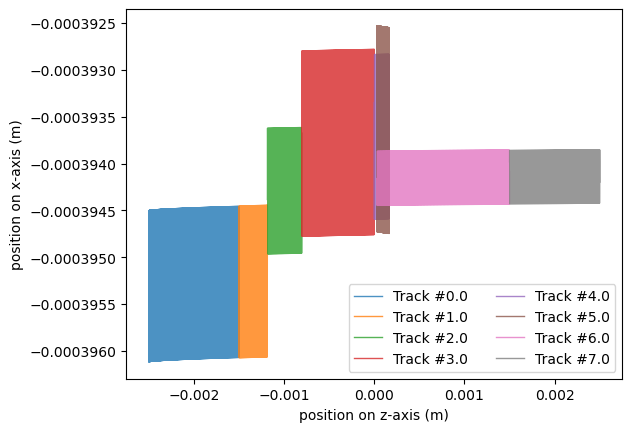

In [15]:
# Make a plot
fig = plt.figure()
plt.xlabel('position on z-axis (m)')
plt.ylabel('position on x-axis (m)')

# Draw step position for each track
for name,group in df.groupby("track_id"):
    plt.plot(group.position_z, group.position_x, marker='', lw=1, alpha=.8, label=f'Track #{name}')
    
plt.legend(ncol=2)

(-0.0014, 0.0014)

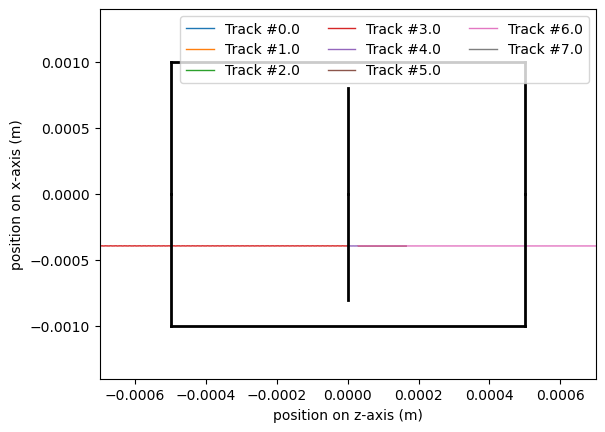

In [16]:
import pyvista as pv

# Open geometry file
dataset = pv.read(WORKDIR + '../TheBag/geometry_painter.vtp')

# Produce a slice along the x-z axis
mesh = dataset.slice(normal=[0,1,0])

# Make a plot
fig = plt.figure()
plt.xlabel('position on z-axis (m)')
plt.ylabel('position on x-axis (m)')

# Draw step position for each track
for name,group in df.groupby("track_id"):
    plt.plot(group.position_z, group.position_x, marker='', lw=1, label=f'Track #{name}')
    
plt.legend(ncol=3)

# Draw lines in each slice cell
for ind in range(mesh.n_cells):
    x, y, z = mesh.cell_points(ind).T

    if mesh.cell_type(ind) == 3:  # VTK_LINE
        line = mpl.lines.Line2D(z, x, lw=2, c='k')
        plt.gca().add_artist(line)
        
        
# Adjust axis limit to make the trap volume visible
plt.xlim(-0.0007, 0.0007)
plt.ylim(-0.0014, 0.0014)